# CSE 252A Computer Vision I Fall 2021 - Assignment 3

## Instructor: Ben Ochoa

- Assignment Published On: **Wed, November 3, 2021**.

- Due On: **Wed, November 17, 2021 11:59 PM (Pacific Time)**.

## Instructions
* This assignment must be completed **individually**. For more details, please follow the Academic Integrity Policy and Collaboration Policy on [Canvas](https://canvas.ucsd.edu/courses/21788).
* All solutions must be written in this notebook.
  * **If** it includes the theoretical problems, you **must** write your answers in Markdown cells (using LaTeX when appropriate).
  * Programming aspects of the assignment must be completed using Python in this notebook.
* You may use Python packages (such as `NumPy` and `SciPy`) for basic linear algebra, but you may not use packages that directly solve the problem.
  * If you are unsure about using a specific package or function, then ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF that contains separate pages. You must also submit this notebook as `.ipynb` file.
  * Submit both files (`.pdf` and `.ipynb`) on Gradescope.
  * **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late Policy:** Assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances. 

## Problem 1: Multiscale image representations [15 pts]

In the [Lecture 9](https://cseweb.ucsd.edu/classes/fa21/cse252A-a/lec9.pdf), given an image, we compare its multiscale representation generated by **Gaussian Image Pyramid** and **Scale-space** methods. The task for this problem is to first build multiscale representations for image `p1/totoro.jpg`, then **comment on** your results obtained by generating a Gaussian pyramid for an image versus those obtained by generating its scale-space representation.

For the Gaussian pyramid, use a binomial kernel of size 5x5 as an approximation for the Gaussian filter. The sampling rate between levels is $rate=2$. 

For the scale-space representation, use a Gaussian filter where the standard deviation depends on the corresponding level of the pyramid (**Hint:** standard deviation $\sigma =  2^{level}$). 

Look at the lecture slides to see the correspondence between pyramid levels and standard deviation for the Gaussian filter in scale space. Also, remember the Gaussian filter dimension is $\lceil 6 \sigma \rceil$ for standard deviation $\sigma$. If the result is an even number, then add 1 to make it odd. 

You need to construct the pyramid and scale-space representation from level 0 to level 10. Note that level 0 is just the original image in both the representations.

Use the provided plotting function to visualize the results.

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import convolve
import scipy.special
import copy

def gaussian2d(filter_size, sig):
    """Creates a 2D Gaussian kernel with side length and a sigma."""
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

def binomial_kernel(size):
    """Creates a binomial filter kernel"""
    coeffs = np.array([scipy.special.binom(size, i) for i in range(size+1)]).reshape((-1,1))
    kernel = np.repeat(coeffs, repeats=size+1, axis=1).T
    kernel = kernel * coeffs
    return kernel/np.sum(kernel)

In [28]:
def gaussian_pyramid(img, num_levels = 10):
    """This function construct the gaussian pyramid for the input image.

    Args:
    img: original image(level-0)
    num_levels: number of levels to generate(level-0 not included)
    
    Returns:
    pyramid: the pyramid as a list consisting of all level images.
             The first element of the list is the original image itself.
    """
    
    pyramid = []
    pyramid.append(img.copy()) # level-0 image
    
    """ ==========
    YOUR CODE HERE
    ========== """
    kernel = binomial_kernel(4)  # (5*5) kernel 
    for i in range(1, 11):
        img[:,:,0] = convolve(img[:,:,0], kernel, mode='same')
        img[:,:,1] = convolve(img[:,:,1], kernel, mode='same')
        img[:,:,2] = convolve(img[:,:,2], kernel, mode='same')
        img = img[::2,::2,:]
        # print(img.shape)
        pyramid.append(img.copy())
    
    return pyramid

In [23]:
def scale_space(img, num_levels = 10):
    """This function construct the scale-space representation for the input image.

    Args:
    img: original image(level-0)
    num_levels: number of levels to generate(level-0 not included)
    
    Returns:
    scale_space: the scale space as a list consisting of all the images in the scale space
             The first element of the list is the original image itself.
    """
    
    scale_space = []
    scale_space.append(img.copy()) # std = 0, level-0 image
    
    """ ==========
    YOUR CODE HERE
    ========== """
    for i in range(1,11):
        img_t = img.copy()
        variance = 2**(i-1)
        kernel_size = 6*(2**(i-1))+1
        kernel = gaussian2d(kernel_size, variance)
        
        # use mirror padding here
        img_pad = np.zeros((img.shape[0]+kernel_size-1, img.shape[1]+kernel_size-1,img.shape[2]))
        img_pad[:,:,0] = np.pad(img_t[:,:,0], kernel_size//2,mode = 'symmetric')
        img_pad[:,:,1] = np.pad(img_t[:,:,1], kernel_size//2,mode = 'symmetric')
        img_pad[:,:,2] = np.pad(img_t[:,:,2], kernel_size//2,mode = 'symmetric')
        
        img_t[:,:,0] = convolve(img_pad[:,:,0], kernel, mode='valid')
        img_t[:,:,1] = convolve(img_pad[:,:,1], kernel, mode='valid')
        img_t[:,:,2] = convolve(img_pad[:,:,2], kernel, mode='valid')
        scale_space.append(img_t.copy())
    

    return scale_space    

In [4]:
def plot_results(pyramid, scale_space):        
    
    print("\t\tGaussian Pyramid\t\t\t Scale Space Representation")
    
    N = len(pyramid)
    std_list = [0] + [2**i for i in range(N-1)]
    for i in range(N):
        pyramid_img = pyramid[i]
        scale_space_img = scale_space[i]
        
        fig = plt.figure(figsize=(12, 9))
        
        ax1 = fig.add_subplot(221)
        ax1.imshow(pyramid_img)
        ax1.axis('off')
        plt.title("Level {}".format(i))
        
        ax2 = fig.add_subplot(222)
        ax2.imshow(scale_space_img)
        ax2.axis('off')
        plt.title("Standard Deviation = {}".format(std_list[i]))
        
        plt.show()

		Gaussian Pyramid			 Scale Space Representation


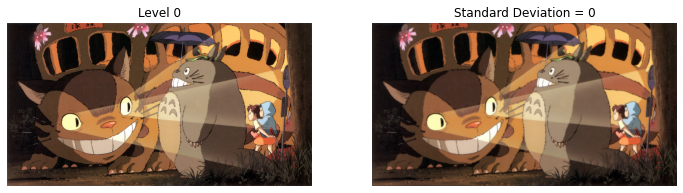

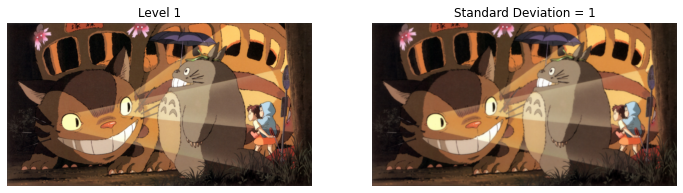

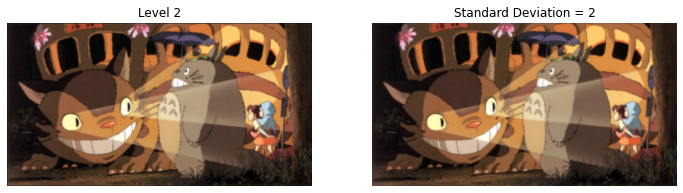

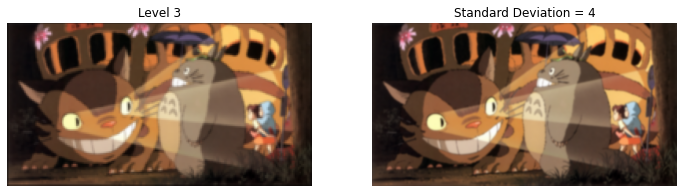

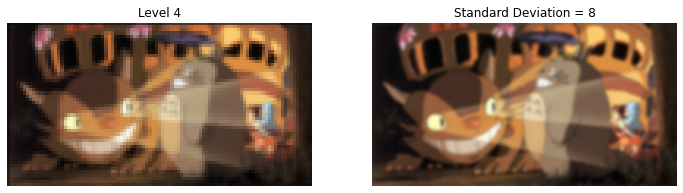

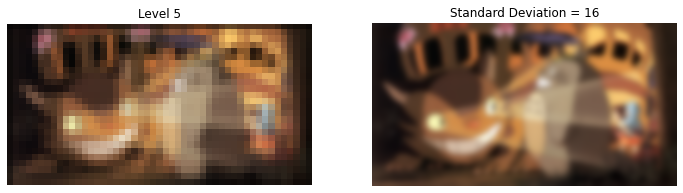

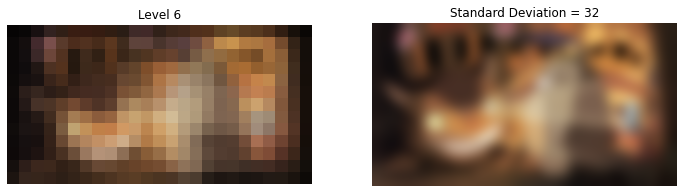

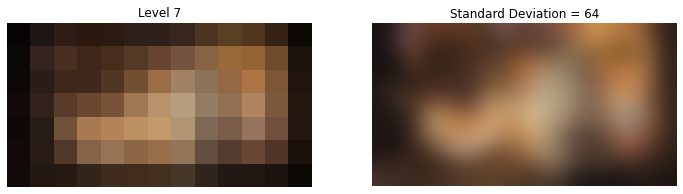

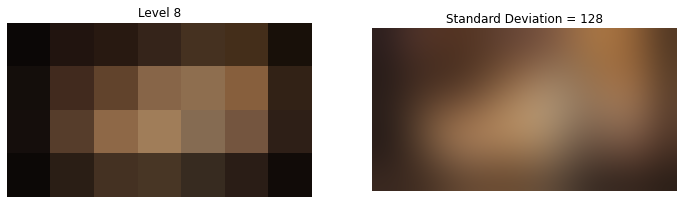

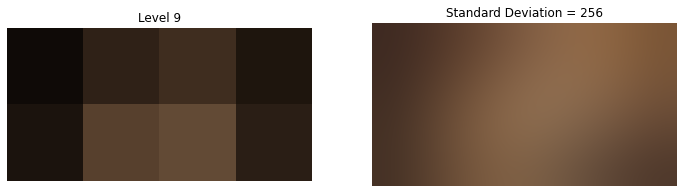

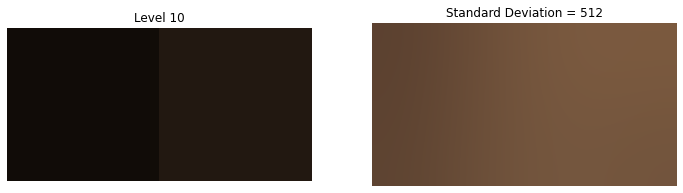

In [29]:
from imageio import imread

""" ==========
YOUR CODE HERE
========== """
img = imread("p1/totoro.jpg")

pyramid = gaussian_pyramid(img, 10)
scale_space_rep = scale_space(img, 10)

plot_results(pyramid, scale_space_rep)

**Comments on your results:**

----------->YOUR COMMENTS HERE<------------




----------->COMMENTS END<------------

## Problem 2: Epipolar Geometry | Uncalibrated Stereo [40 points]

In Assignment 2, we worked with calibrated cameras (i.e., calibration matrices $K_1$ and $K_2$, camera rotation matrices $R_1$ and $R_2$, camera translation vectors $t_1$ and $t_2$) to solve calibrated stereo. 

In this problem, we are interested in recovering the stereo information without the use of a calibration process. Specifically, given ground-truth correspondences from a pair of images, your task is to estimate the fundamental matrix and recover the epipolar geometry.

### Problem 2.1 Fundamental matrix [12 points]

Complete the `compute_fundamental` function below using the 8-point algorithm described in lecture. Note that the normalization of the corner points is handled in the `fundamental_matrix` function.

**Hint:** Feel free to use any basic Python packages to solve the singular value decomposition. However, read the corresponding documents to make sure about the form of parameters and returns.

In [ ]:
def compute_fundamental(x1, x2):
    """    
    Computes the fundamental matrix from corresponding points using the 8 point algorithm.
    Args:
        x1: normalized homogeneous matching points from image1(3xN)
        x2: normalized homogeneous matching points from image2(3xN)
    Returns:
        F: Fundamental Matrix (3x3)
    """
    
    F = np.ones((3,3))
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    return F

def fundamental_matrix(x1,x2):
    """    
    Computes the fundamental matrix from corresponding points
    
    Args:
        x1: unnormalized homogeneous points from image1(3xN)
        x2: unnormalized homogeneous points from image2(3xN)
        
    Returns:
        Fundamental Matrix (3x3)
    """
        
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return (F/np.linalg.norm(F))

In [ ]:
# TEST CODE, DO NOT MODIFY
# Here is the code for you to test your implementation
cor1 = np.load("./p2/"+'dino'+"/cor1.npy")
cor2 = np.load("./p2/"+'dino'+"/cor2.npy")
print(fundamental_matrix(cor1, cor2))

# should print 
# [[ 4.00480819e-07  3.09602270e-06 -2.86950511e-03]
#  [-2.69886048e-06 -1.00966950e-08  6.70416604e-03]
#  [ 1.37812305e-03 -7.29636272e-03  9.99945841e-01]]

### Problem 2.2 Epipoles [6 points]

In this part, you are supposed to complete the function <code>compute_epipole</code> to calculate the epipoles for a given fundamental matrix.

In [ ]:
def compute_epipole(F):
    """
    This function computes the epipoles for a given fundamental matrix.
    
    Args:
      F: fundamental matrix
      
    Returns:
      e1: corresponding epipole in image1
      e2: corresponding epipole in image2
    """
    e1 = np.array([0, 0, 0])
    e2 = np.array([0, 0, 0])
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    return e1,e2

In [ ]:
# TEST CODE, DO NOT MODIFY
# Here is the code for you to test your implementation
F_test = np.array([[1, 2, 1], [6, 5, 4], [9, 8, 1]])
print(compute_epipole(F_test))
# should print 
#(array([-65.3659783 ,  15.85984739,   1.        ]), 
#array([-41.86658577,  46.87378417,   1.        ]))

### Problem 2.3: Epipolar Lines [12 points]

For this part, given pairs of images, your task is to plot the epipolar lines in both images for each image pair. You will want to complete the function <code>plot_epipolar_lines</code> using the `fundamental_matrix` function you just got. 
 
The figure below gives you an idea on how the final results look on **dino**. Show your results for **matrix** and **warrior**.
![Dino Epipolar](fig/eg_dino_epipolar_lines.png) 

In [ ]:
def plot_epipolar_lines(img1, img2, F, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        F:    Fundamental matrix
        cor1: Corners in homogeneous image coordinate in image 1 (3xN)
        cor2: Corners in homogeneous image coordinate in image 2 (3xN)
    """
    
    assert cor1.shape[0] == 3
    assert cor2.shape[0] == 3
    assert cor1.shape == cor2.shape
    
    """ ==========
    YOUR CODE HERE
    ========== """


In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 
# The total number of outputs is 4 images in 2 pairs

imgids = ["matrix", "warrior"]
for imgid in imgids:
    I1 = imread("./p2/"+imgid+"/"+imgid+"0.png")
    I2 = imread("./p2/"+imgid+"/"+imgid+"1.png")
    cor1 = np.load("./p2/"+imgid+"/cor1.npy")
    cor2 = np.load("./p2/"+imgid+"/cor2.npy")
    F = fundamental_matrix(cor1, cor2)
    plot_epipolar_lines(I1,I2,F,cor1,cor2)

### Problem 2.4: Uncalibrated Stereo Image Rectification [10 points]

In Assignment 2, you performed epipolar rectification with calibrated stereo cameras. Rectifying a pair of images can also be done for uncalibrated camera images. Using the fundamental matrix we can find the pair of epipolar lines $\boldsymbol{l_i}$ and $\boldsymbol{l^{'}_i}$ for each of the correspondences. The intersection of these lines will give us the respective epipoles $\boldsymbol{e}$ and $\boldsymbol{e^{'}}$. Now to make the epipolar lines to be parallel we need to map the epipoles to infinity. Hence, we need to find a homography that maps the epipoles to infinity.
 
The rectificaton method has already been implemented for you. You can get more details from the paper *Theory and Practice of Projective Rectification* by Richard Hartley.

Your task is to:

1) complete the `warp_image` function (**Hint:** You may reuse some of the codes from Homework2, but this time we perform the warp of the full image content. The size of the output image is bounded by the **bounding box**).

2) use the given `image_rectification` function to find the rectified images

3) plot the parallel epipolar lines using the `plot_epipolar_lines` function from above.

The figure below gives you an idea on how the final results look (Note that the two images may not be in the same shape). Show your result for **matrix** and **warrior**.
![House Rectification](fig/exp_house_rectify.png) 

In [ ]:
def warp_image(image, H):
    """
    Performs the warp of the full image content.
    Calculates bounding box by piping four corners through the transformation.
    Args: 
        image: Image to warp
        H: The image rectification transformation matrices.
    Returns:
        Out: An inverse warp of the image, given a homography.
        min_x, min_y: The minimum/maxmum of warped image bound.
    """
#     out_height, out_width = max_y - min_y, max_x - min_x

    """ ==========
    YOUR CODE HERE
    ========== """

    return out, min_x, min_y

In [ ]:
from math import floor, ceil

def compute_matching_homographies(e2, F, im2, points1, points2):
    """This function computes the homographies to get the rectified images.
    
    Args: 
    e2: epipole in image 2
    F: the fundamental matrix (think about what you should be passing: F or F.T!)
    im2: image2
    points1: corner points in image1
    points2: corresponding corner points in image2
    
    Returns:
    H1: homography for image 1
    H2: homography for image 2
    """
    # calculate H2
    width = im2.shape[1]
    height = im2.shape[0]

    T = np.identity(3)
    T[0][2] = -1.0 * width / 2
    T[1][2] = -1.0 * height / 2

    e = T.dot(e2)
    e1_prime = e[0]
    e2_prime = e[1]
    if e1_prime >= 0:
        alpha = 1.0
    else:
        alpha = -1.0

    R = np.identity(3)
    R[0][0] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[0][1] = alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][0] = - alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][1] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)

    f = R.dot(e)[0]
    G = np.identity(3)
    G[2][0] = - 1.0 / f

    H2 = np.linalg.inv(T).dot(G.dot(R.dot(T)))

    # calculate H1
    e_prime = np.zeros((3, 3))
    e_prime[0][1] = -e2[2]
    e_prime[0][2] = e2[1]
    e_prime[1][0] = e2[2]
    e_prime[1][2] = -e2[0]
    e_prime[2][0] = -e2[1]
    e_prime[2][1] = e2[0]

    v = np.array([1, 1, 1])
    M = e_prime.dot(F) + np.outer(e2, v)

    points1_hat = H2.dot(M.dot(points1.T)).T
    points2_hat = H2.dot(points2.T).T

    W = points1_hat / points1_hat[:, 2].reshape(-1, 1)
    b = (points2_hat / points2_hat[:, 2].reshape(-1, 1))[:, 0]

    # least square problem
    a1, a2, a3 = np.linalg.lstsq(W, b, rcond=None)[0]
    HA = np.identity(3)
    HA[0] = np.array([a1, a2, a3])

    H1 = HA.dot(H2).dot(M)
    return H1, H2

In [ ]:
def image_rectification(im1, im2, points1, points2):
    """This function provides the rectified images along with the new corner points as
    images with corner correspondences
    
    Args:
    im1: image1
    im2: image2
    points1: corner points in image1
    points2: corner points in image2
    
    Returns:
    rectified_im1: rectified image 1
    rectified_im2: rectified image 2
    new_cor1: new corners in the rectified image 1
    new_cor2: new corners in the rectified image 2
    """
    F = fundamental_matrix(points1, points2)
    e1, e2 = compute_epipole(F)
    H1, H2 = compute_matching_homographies(e2, F.T, im2, points1.T, points2.T)
    
    # Apply homographies
    rectified_im1, min_x1, min_y1 = warp_image(im1, H1)
    rectified_im2, min_x2, min_y2 = warp_image(im2, H2)

    new_cor1 = np.dot(H1, points1) # 3 x n
    new_cor1 /= new_cor1[-1, :]
    new_cor1[0, :] -= min_x1
    new_cor1[1, :] -= min_y1
    new_cor2 = np.dot(H2, points2)
    new_cor2 /= new_cor2[-1, :]
    new_cor2[0, :] -= min_x2
    new_cor2[1, :] -= min_y2
    return rectified_im1, rectified_im2, new_cor1, new_cor2

In [ ]:
# This code is for you to plot the results. 
# The total number of outputs is 4 images in 2 pairs

imgids = ["matrix", "warrior"]
for imgid in imgids:
    print("./p2/"+imgid+"/"+imgid+"0.png")
    I1 = imread("./p2/"+imgid+"/"+imgid+"0.png")
    I2 = imread("./p2/"+imgid+"/"+imgid+"1.png")
    
    cor1 = np.load("./p2/"+imgid+"/cor1.npy")
    cor2 = np.load("./p2/"+imgid+"/cor2.npy")
    
    """ ==========
    YOUR CODE HERE
    ========== """


## Problem 3: Fundamental Matrix Estimation with RANSAC [40 pts]

In problem 2, you have `fundamental_matrix` function which calculates the fundamental matrix $F$ from matching pairs of points in two different images. In this problem, we will first implement a SIFT (Scale-Invariant Feature Transform)-pipeline that detects feature points and identifies matching points between two images. Then we estimate the fundamental matrix $F$ with those matching points using RANSAC method.

**Instruction:** You can use basic functions/objects in OpenCV, but you may not use functions that directly solve the problem unless specified.

### Problem 3.1: SIFT Feature Detection [5 pts]

Let's get some experience with SIFT detection. You may refer to [SIFT Python tutorial](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html) and OpenCV [cv::SIFT Class Reference](https://docs.opencv.org/4.5.1/d7/d60/classcv_1_1SIFT.html) according to your OpenCV version. For more details and understanding, reading [the original paper](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) is highly recommended. 

The following example plots keypoints on `p2/dino/dino0.png`. Your task is to plot a similar image for `p2/dino/dino1.png`.
<center><img src="fig/eg_dino_sift.png" alt="DINO SIFT" width="400" align="center"/></center>

For this part ONLY(Problem 3.1), you will use any OpenCV functions you need.

In [ ]:
import cv2
def get_sift_features_plot(image):
    """This function draws SIFT features
    
    Args:
    image:rgb image
    
    Returns:
    keypoint_image: image with key points drawn on
    """
    keypoint_image = image.copy()
        
    """ ==========
    YOUR CODE HERE
    ========== """
    
    return keypoint_image

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 
image = imread('p2/dino/dino1.png')
keypointimage = get_sift_features_plot(image)
plt.imshow(keypointimage)

### Problem 3.2: SIFT Feature Matching [10 pts]

Let's try to match the SIFT features from a pair of images. You will be using [cv::BFMatcher](https://docs.opencv.org/4.5.3/d3/da1/classcv_1_1BFMatcher.html), a Brute-force descriptor matcher in OpenCV. Also, we will draw lines between the features that match in both the images like you did in Homework 2. However, you will use [OpenCV Drawing Functions](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html) this time.
Complete the `get_matches_sift` and `create_matching_image` functions to draw a pair of matched images. The following example plots the result for **dino**, your task is to plot the result for **skull-book**.
![DINO MATCHING](fig/eg_dino_sift_matching.png)
For this part(Problem 3.2), you will use `cv::BFMatcher` and `cv::SIFT` related modules from OpenCV library.

In [ ]:
def get_matches_sift(img1, img2):
    """This function detects matching points from a pair of images
        using SIFT feature detection and Brute force descriptor matcher.
    Args:
        img1: Grayscale image1
        img2: Grayscale image2
    Returns:
        corners1: numpy array that contains matching corners from image1 in image coordinates(Nx2)
        corners2: numpy array that contains matching corners from image2 in image coordinates(Nx2)
    """

    """ ==========
    YOUR CODE HERE
    ========== """
    
    return corners1, corners2
def create_matching_image(img1, img2, corners1, corners2):
    """This function create a matching result image from a pair of images
       and their correspondences.
    Args:
        img1: rgb image1
        img2: rgb image2
        corners1: matching points in image1 in image coordinates(Nx2)
        corners2: matching points in image2 in image coordinates(Nx2)
    Returns:
        matching_img: the result rgb matching image. 
    """
    
    h1, w1, _ = img1.shape;h2, w2, _ = img2.shape;
    height = max(h1, h2); width = w1+w2
    matching_img = np.zeros((height, width, 3), dtype=img1.dtype)
    
    """ ==========
    YOUR CODE HERE
    ========== """

    return matching_img

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 

# read images
img1 = imread('p3/skull-book1.jpg')  
img2 = imread('p3/skull-book2.jpg') 

corners1, corners2 = get_matches_sift(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY),\
                                      cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY))

print('Found {:d} possibly matching features'.format(corners1.shape[0]))
match_image = create_matching_image(img1, img2, corners1, corners2)
plt.figure(figsize=(16,8));plt.imshow(match_image); plt.show()

### Problem 3.3: Calculate the Fundamental Matrix using RANSAC [25 pts]

Now you have `fundamental_matrix` function which calculates the fundamental matrix $F$ and a set of potential matching points using SIFT and BFMatcher. However, as you see from Problem 3.2, unlike the Problem 2, the SIFT-pipeline doesn't guarantee that those points are perfectly matched. Therefore, we will implement the RANdom SAmple Consensus (RANSAC) method from the lecture to search through the potential matching points and remove those false-matches(outliers) to use for calculating the fundamental matrix.

Complete `fundamental_matrix_ransac` to estimate fundamental matrix with RANSAC method. You will implement `compute_consensus_set` as a building block to find a consensus set. You will also complete functions to calculate distance by $L^2$ distance of points to epipolar line(`point2line_l2_dist`)

In [ ]:
def to_homog(points):
    """convert points from euclidean to homogeneous
    """
    m, n = points.shape
    homo_points = np.vstack((points, np.ones(n)))
    return homo_points

def point2line_l2_dist(point, line):
    """This function provides L^2 distance of point to (epipolar) line
    Args:
        point: 2D homogeneous point
        line: (a,b,c) for ax+by+c=0
    Returns:
        distance: L^2 distance of point to line
    """
    """ ==========
    YOUR CODE HERE
    ========== """

    return distance

def compute_consensus_set(x1, x2, F, threshold):
    """This function find consensus set of points for current F
    Args:
        x1: homogeneous points from image1(3xN)
        x2: homogeneous points from image2(3xN)
        F: fundamental matrix
        threshold: the maximum distance allowed for a correspondence
    Returns:
        inliers: numpy array that contains indices of the inliers in x1 and x2
    """
    inliers = []
    
    """ ==========
    YOUR CODE HERE
    ========== """
            
    return np.array(inliers) 
    

def compute_N(p, s, inlier_p):
    if inlier_p>0.99:
        return 0
    return int(np.log(1 - p) / np.log(1 - inlier_p ** s))

In [ ]:
def fundamental_matrix_ransac(x1, x2, threshold=100, confidence=0.95, iter_limit=5000):
    """    
    Computes the fundamental matrix with RANSAC
    Use RANSAC to find the best fundamental matrix by randomly sampling interest points.
    Args:
        x1: possibly matching points from image1(2xN)
        x2: possibly matching points from image2(2xN)
        threshold: distance threshold
        confidence: confidence value, 0.95 by default
        iter_limit: maximum iterations to force running stop
        
    Returns:
        best_F: the best Fundamental Matrix (3x3)
        x1_inliers: A numpy array(2xM) representing the true match points(inliers)
                    from the image1 with respect to best_F
        x2_inliers: A numpy array(2xM) representing the true match points(inliers)
                    from the image2 with respect to best_F        
    """
    """ ==========
    YOUR CODE HERE
    ========== """
    
    return best_F, x1_inliers, x2_inliers

First, test your implementation on **warrior** with ground truth matches. The two pairs of images 1) the matching pair with F estimated from the whole set set of corners and 2) the matching pair with F estimated with RANSAC method. The two matching pairs should look very similar.

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 

imgids = [ "warrior"]
for imgid in imgids:
    print("./p2/"+imgid+"/"+imgid+"0.png")
    I1 = imread("./p2/"+imgid+"/"+imgid+"0.png")
    I2 = imread("./p2/"+imgid+"/"+imgid+"1.png")
    
    cor1 = np.load("./p2/"+imgid+"/cor1.npy")
    cor2 = np.load("./p2/"+imgid+"/cor2.npy")
    
    print('Found {:d} possibly matching features'.format(cor1.shape[1]))
    
    F_all = fundamental_matrix(cor1, cor2)
    match_image_all = create_matching_image(I1, I2, cor1.T, cor2.T)
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1); plt.imshow(match_image_all);

    F, x1_in, x2_in = fundamental_matrix_ransac(cor1[:2,:], cor2[:2,:], dist_func='epi', threshold=1.0)
    match_image = create_matching_image(I1, I2, x1_in.T, x2_in.T)
    print('\n\tF estimated with whole set of points\t\t\t\t F estimated with RANSAC')
    
    plt.subplot(1,2,2); plt.imshow(match_image); plt.show()   


Then, show your results for **skull-book**. You can tweak the parameters to `fundamental_matrix_ransac` to optimize your results. 

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results.  

def plot_matching_origin(I1, I2, corners1, corners2):
    F_all = fundamental_matrix(to_homog(corners1.T), to_homog(corners2.T))
    match_image_all = create_matching_image(I1, I2, corners1, corners2)
    print('\n F estimated with whole set of points')
    plt.figure(figsize=(16,8)); plt.imshow(match_image_all)

def plot_matching_RANSAC(I1, I2, corners1, corners2, l2_thresh):
    F_l2, x1_in_l2, x2_in_l2 = fundamental_matrix_ransac(corners1.T, corners2.T, threshold=l2_thresh)
    match_image_l2 = create_matching_image(I1, I2, x1_in_l2.T, x2_in_l2.T)
    print('F estimated with RANSAC, Dist threshold='+str(l2_thresh))
    plt.figure(figsize=(16,8)); plt.imshow(match_image_l2);

In [ ]:
# LOAD CODE: DO NOT MODIFY
I1 = imread("./p3/skull-book1.jpg");scale_a=0.5;
I2 = imread("./p3/skull-book2.jpg");scale_b=0.5;

I1 = cv2.resize(I1, \
                (int(I1.shape[1] * scale_a), int(I1.shape[0] * scale_a)),\
                interpolation = cv2.INTER_AREA)
I2 = cv2.resize(I2, \
                (int(I2.shape[1] * scale_b), int(I2.shape[0] * scale_b)),\
                interpolation = cv2.INTER_AREA)

corners1, corners2 = get_matches_sift(cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY),\
                                  cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY))
print('Found {:d} possibly matching features'.format(corners1.shape[0]))

In [ ]:
# PLOT CODE: DO NOT MODIFY

plot_matching_origin(I1, I2, corners1, corners2)
plt.show()

In [ ]:
l2_thresh = 100 #You can tweak this

#PLOT CODE: DO NOT MODIFY
plot_matching_RANSAC_L2(I1, I2, corners1, corners2, l2_thresh)
plt.show()

Finally, choose ANY ONE SETTING of RANSAC method to plot epipolar lines using `plot_epipolar_lines` function from Problem 2.3 on **skull-book**.

In [ ]:
I1 = imread("./p3/skull-book1.jpg");scale_a=0.5;
I2 = imread("./p3/skull-book2.jpg");scale_b=0.5;

I1 = cv2.resize(I1, \
                (int(I1.shape[1] * scale_a), int(I1.shape[0] * scale_a)),\
                interpolation = cv2.INTER_AREA)
I2 = cv2.resize(I2, \
                (int(I2.shape[1] * scale_b), int(I2.shape[0] * scale_b)),\
                interpolation = cv2.INTER_AREA)
""" ==========
YOUR CODE HERE
========== """


## Problem 4: Optical Flow [15 pts]

In this problem, we will implement the multi-resolution Lucas-Kanade algorithm to estimate optical flow.

An example optical flow output is shown below - this is not a solution, just an example output.

![title](fig/sample_optical_flow_output.png)

### Problem 4.1: Lucas-Kanade implementation [15 pts]

Implement the Lucas-Kanade method for estimating optical ﬂow. Fill in the function `compute_LK`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,-V1)
    plt.title(titleStr)
    plt.show()


In [ ]:
images=[]
for i in range(1,5):
    # each image after converting to gray scale is of size -> 400x288
    images.append(plt.imread('p4/im'+str(i)+'.png')[:,:288,:])

In [ ]:
# computes simple Lucas-Kanade Optical Flow
def compute_LK(img1, img2, window, u_prev=None, v_prev=None):
    """ ==========
    YOUR CODE HERE
    ========== """

            
    return U, V

In [ ]:
# PLOT CODE: DO NOT MODIFY
## Test your implementation on sample parameter values
window = 60
U, V = compute_LK(grayscale(images[0]),grayscale(images[1]), window)
# Plot
plot_optical_flow(images[0],U,V, 'window = '+str(window))

**Test with different Window size:**

Plot optical ﬂow for the pair of images im1 and im2 for at least 3 diﬀerent window sizes which leads to observable diﬀerence in the results. Comment on the eﬀect of window size on results and justify.

In [ ]:
windows=[5,20,60]

for i in range(3):
    U,V=compute_LK(grayscale(images[0]),grayscale(images[1]),windows[i])
    plot_optical_flow(images[0],U,V,'window size='+str(windows[i]))

**Your comments here:**

### Problem 4.2: Multi-resolution Lucas-Kanade implementation[Optional][0 pts]

**NOTE: This problem is optional. Your submission for this problem would be graded but you would not receive a score for solving this problem. However, you are welcome and encouraged to try it out and bring any questions that you have to the instructional team.**


Implement the Lucas-Kanade method for estimating optical flow. The function `LucasKanadeMultiScale` needs to be completed. You can implement `upsample_flow` and `OpticalFlowRefine` as 2 building blocks in order to complete this.

In [ ]:
# you can use interpolate from scipy
# You can implement 'upsample_flow' and 'OpticalFlowRefine' 
# as 2 building blocks in order to complete this.
def upsample_flow(u_prev, v_prev):
    ''' You may implement this method to upsample optical flow from previous level
    Args:
        u_prev, v_prev: optical flow from prev level
    Returns:
        u, v: upsampled optical flow to the current level
    '''
    """ ==========
    YOUR CODE HERE
    ========== """
    
    return u, v

def OpticalFlowRefine(im1,im2,window, u_prev=None, v_prev=None):
    '''
    Inputs: the two images at current level and window size
    u_prev, v_prev - previous levels optical flow
    Return u,v - optical flow at current level
    '''   
    """ ==========
    YOUR CODE HERE
    ========== """
    
    return u, v

In [ ]:
from skimage.transform import resize

def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    
    return u, v

In [ ]:
numLevels=5
window = 17
U, V = LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
# # Plot
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

#### Problem 4.2.2: Number of levels

Plot optical flow for the pair of images im1 and im2 for different number of levels mentioned below. Comment on the results and justify.<br>
(i) window size = 13, numLevels = 1<br>
(ii) window size = 13, numLevels = 3<br>
(iii) window size = 13, numLevels = 5<br>
So, you are expected to provide 3 outputs here<br>

Note: if numLevels = 1, then it means the optical flow is only computed at the image resolution i.e. no downsampling

In [ ]:
# Example code to generate output
numLevels=1
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

numLevels=3
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
# Plot
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

numLevels=5
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
# Plot
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

**Your comments here**

#### Problem 4.2.3: Window size

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which leads to observable difference in the results. Comment on the effect of window size on results and justify. For this part fix the number of levels to be 3.

In [ ]:
# Example code, change as required
numLevels=3

w1, w2, w3 = 7, 11, 17
for window in [w1, w2, w3]:
    U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                              window,numLevels)
    plot_optical_flow(images[0],U,V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window))

**Your comments here:**

#### Problem 4.2.4 All pairs

Find optical ﬂow for the pairs (im1,im2), (im1,im3), (im1,im4) for a range of window sizes. Submit the best result for each pair. Does the optical ﬂow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

In [ ]:
# use one fixed window and numLevels for all pairs
numLevels = 5
window = 17
""" ==========
YOUR CODE HERE
========== """

**Your Comments here:**